In [ ]:
# pip install tensorflow-gpu

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in dirname:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Preparing data generators

In [ ]:
import os, pickle

In [ ]:
import keras
keras.__version__

In [ ]:
base_dir = '/kaggle/input/dogs-vs-cats_data'
train_full = pickle.load(open(os.path.join(base_dir, 'train_data.pkl'), 'rb'))
val_full = pickle.load(open(os.path.join(base_dir, 'validation_data.pkl'), 'rb'))
test_full = pickle.load(open(os.path.join(base_dir, 'test_data.pkl'), 'rb'))

In [ ]:
train_data = np.array([image for image in train_full['images']])
train_labels = np.array(train_full['label'])
val_data = np.array([image for image in val_full['images']])
val_labels = np.array(val_full['label'])
test_data = np.array([image for image in test_full['images']])
test_labels = np.array(test_full['label'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_data, train_labels, batch_size=20)

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

In [ ]:
val_generator = val_datagen.flow(val_data, val_labels, batch_size=20)

# The Model

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                      input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=100, 
                             epochs=30, validation_data=val_generator,
                             validation_steps=50)

In [ ]:
model.save('/kaggle/working/cats_and_dogs_small_1.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/kaggle/working/cats_and_dogs_small_1.h5')
model.summary()


# Visualizing CNNs

# 1. Covnet filters

In [1]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)
model.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [3]:
layer_name = 'block5_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
layer_output

<tf.Tensor 'block5_conv1/Relu:0' shape=(None, None, None, 512) dtype=float32>

In [4]:
loss = K.mean(layer_output[:, :, :, filter_index])
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [28]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
grads.shape

TensorShape([None, None, None, 3])

In [31]:
iterate = K.function([model.input], [loss,grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])
# grads_value

array([[[[ 6.52502179e-01,  9.90261018e-01, -1.27052367e+00],
         [ 2.66827375e-01,  1.29348075e+00, -2.63657665e+00],
         [-1.94243157e+00,  9.45576072e-01, -4.74165869e+00],
         ...,
         [-1.17769337e-03,  7.24558160e-03, -7.01724738e-03],
         [ 2.01723864e-03,  1.54280243e-02,  1.13271375e-03],
         [ 1.79078465e-03,  9.92367696e-03,  2.74744187e-03]],

        [[ 1.47344458e+00,  2.79033446e+00, -1.18648291e+00],
         [ 8.78323734e-01,  3.99869466e+00, -2.91261435e+00],
         [-2.36422634e+00,  4.93374300e+00, -5.18616295e+00],
         ...,
         [ 1.42367883e-03,  1.44072557e-02, -1.15162795e-02],
         [ 1.00315325e-02,  3.17274295e-02,  6.51870808e-03],
         [ 8.94455425e-03,  2.26873457e-02,  1.00859934e-02]],

        [[ 2.18261912e-01,  4.37855434e+00, -1.45923531e+00],
         [-1.18904734e+00,  7.49393797e+00, -2.73892045e+00],
         [-4.84448481e+00,  1.14798498e+01, -3.71633744e+00],
         ...,
         [ 1.51891280e-0

In [30]:
input_img = np.random.random((1,150,150,3)) * 20 + 128

step = 1
for i in range(40):
    loss_val,grads_val = iterate([input_img])
    input_img += grads_val * step

In [38]:
input_img.mean()

127.05573333333334

In [41]:
def deprocess_image(x):
    x = x.astype('float64')
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x,0,1)
    
    x *= 255
    x = x.astype('uint8')
    return x

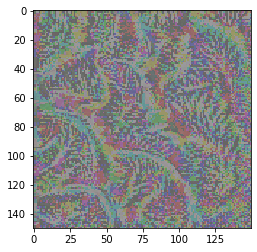

In [42]:
import matplotlib.pyplot as plt

image = deprocess_image(input_img[0])
plt.imshow(image)

# 2. Visualizing filters

In [43]:
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, _ = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


ValueError: Colormap cividi is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

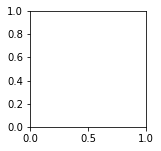

In [60]:
filters, _ = model.layers[1].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters-f_min) / (f_max-f_min)
plt.figure(figsize=(20,20))
n_filters, ix = 8, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        plt.imshow(f[:,:,j], cmap='cividis')
        ix += 1

plt.show()